In [1]:
# Main imports
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV, LinearRegression,
                                  MultiTaskElasticNet, MultiTaskElasticNetCV)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd

from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import osmnx as ox
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
ox.config(use_cache=True, log_console=False)

In [3]:
src = rasterio.open('LongNTL_2020.tif')

In [4]:
data = pd.read_csv("./LightPollution/Newyork_final.csv")
data = gpd.GeoDataFrame(
    data.loc[:, [c for c in data.columns if c != "geometry"]],
    geometry = gpd.GeoSeries.from_wkt(data["geometry"]),
    crs="EPSG:4326")
data.drop(["Unnamed: 0"], axis = 1, inplace = True)
data

,highway,barrier,amenity,railway,source,created_by,ele,gnis:ST_alpha,gnis:county_name,gnis:created,...,industrial_mean_distance,industrial_mean_NTL,residential_mean_distance,residential_mean_NTL,retail_mean_distance,retail_mean_NTL,Over_illumination,Trespass,Clutter,geometry
0,NaN,NaN,NaN,NaN,USGS Geonames,NaN,57.0,NaN,Richmond,NaN,...,1499.799134,21.715000,980.436306,30.448999,NaN,NaN,6978.385254,1.158790,0.001883,POINT (-74.10875 40.61288)
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1766.427190,83.071060,1080.119930,75.307503,NaN,NaN,25959.957031,4.971072,0.004660,POINT (-73.94218 40.71451)
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1547.623714,46.626431,1727.613252,45.167004,2337.665507,43.049999,21448.279297,3.933606,0.003493,POINT (-73.78277 40.71336)
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1369.112027,48.406666,1219.125280,51.943748,NaN,NaN,22743.470703,4.411847,0.003901,POINT (-73.78773 40.71121)
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2785.868604,66.547501,1632.834446,66.995003,1594.305110,142.221664,25494.355469,3.538215,0.013498,POINT (-73.98170 40.77109)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1762.524862,33.764999,1460.061130,37.807320,NaN,NaN,8295.750000,1.579930,0.002167,"MULTIPOLYGON (((-74.09486 40.61965, -74.09516 ..."
2880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1038.713569,40.089642,1590.839616,37.345001,5591.124023,0.870827,0.002417,"MULTIPOLYGON (((-74.15693 40.61759, -74.15686 ..."
2881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1306.626044,37.240623,1862.610861,38.107502,7035.559570,0.973538,0.002542,"MULTIPOLYGON (((-74.14902 40.60718, -74.14787 ..."
2882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1183.047542,33.764999,1813.861081,38.436317,NaN,NaN,10401.265625,1.708810,0.003122,"MULTIPOLYGON (((-74.07518 40.60726, -74.07509 ..."


In [5]:
features = ['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL',
            'commercial', 'commercial_mean_distance', 'commercial_mean_NTL',
            'construction', 'construction_mean_distance', 'construction_mean_NTL',
            'farmland', 'farmland_mean_distance', 'farmland_mean_NTL',
            'forest', 'forest_mean_distance', 'forest_mean_NTL', 
            'grass',  'grass_mean_distance', 'grass_mean_NTL',
            'industrial', 'industrial_mean_distance', 'industrial_mean_NTL',
            'residential', 'residential_mean_distance', 'residential_mean_NTL', 
            'retail', 'retail_mean_distance', 'retail_mean_NTL']
len(features)

27

In [6]:
mean_val = data.mean()
data = data.fillna(mean_val)

In [7]:
data["Over_illumination"] = (data["Over_illumination"] - data["Over_illumination"].min()) / (data["Over_illumination"].max() - data["Over_illumination"].min())
data["Trespass"] = (data["Trespass"] - data["Trespass"].min()) / (data["Trespass"].max() - data["Trespass"].min())
data["Clutter"] = (data["Clutter"] - data["Clutter"].min()) / (data["Clutter"].max() - data["Clutter"].min())

In [8]:
data[["Over_illumination", "Trespass", "Clutter"]]

,Over_illumination,Trespass,Clutter
0,0.123932,0.097967,0.085396
1,0.468562,0.424252,0.227863
2,0.386648,0.335458,0.168016
3,0.410163,0.376389,0.188939
4,0.460109,0.301617,0.681284
...,...,...,...
2879,0.147850,0.134012,0.099993
2880,0.098745,0.073321,0.112791
2881,0.124970,0.082112,0.119233
2882,0.186078,0.145042,0.148989


In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['residential', 'residential_mean_distance', 'residential_mean_NTL']]].values)
T = scaler.fit_transform(data[['residential', 'residential_mean_distance', 'residential_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary.reset_index(inplace=True)

Summary["Treatment"] = "residential"

Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.312,0.021,14.857,0.0,0.277,0.347,residential
1,0,Y1,0.214,0.020,10.682,0.0,0.181,0.246,residential
2,0,Y2,0.233,0.025,9.214,0.0,0.192,0.275,residential


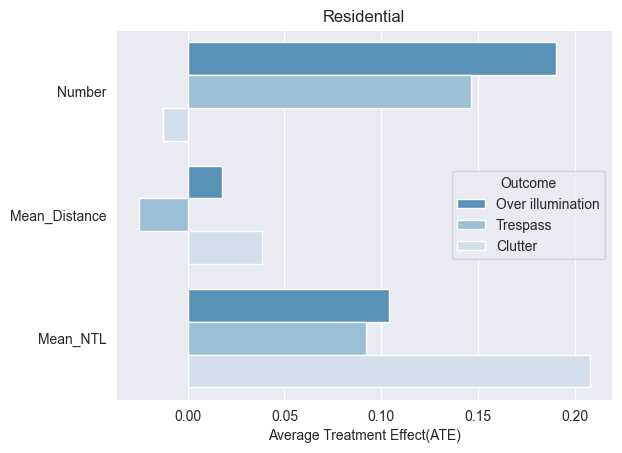

In [11]:
residential_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
residential_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
residential_effect = pd.melt(residential_effect, id_vars=["Treatment"], var_name = "Outcome")
residential_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = residential_effect,
    y="Treatment", x="value", hue="Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)
g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title="Residential")
plt.legend(title = "Outcome", loc="center right")
plt.savefig("residential5.svg", bbox_inches = "tight")

In [12]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['commercial', 'commercial_mean_distance', 'commercial_mean_NTL']]].values)
T = scaler.fit_transform(data[['commercial', 'commercial_mean_distance', 'commercial_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary.reset_index(inplace=True)

summary["Treatment"] = "commercial"
summary
Summary = pd.concat([Summary, summary], axis = 0)

Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.312,0.021,14.857,0.0,0.277,0.347,residential
1,0,Y1,0.214,0.020,10.682,0.0,0.181,0.246,residential
2,0,Y2,0.233,0.025,9.214,0.0,0.192,0.275,residential
0,0,Y0,0.144,0.021,6.844,0.0,0.109,0.179,commercial
1,0,Y1,0.084,0.017,5.052,0.0,0.057,0.112,commercial
2,0,Y2,0.193,0.044,4.347,0.0,0.120,0.266,commercial


In [13]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['retail', 'retail_mean_distance', 'retail_mean_NTL']]].values)
T = scaler.fit_transform(data[['retail', 'retail_mean_distance', 'retail_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3),
                model_t = MultiTaskElasticNetCV(cv = 3),
                linear_first_stages = True)

est.fit(Y, T, W = W)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "retail"
Summary = pd.concat([Summary, summary], axis = 0)
Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.312,0.021,14.857,0.00,0.277,0.347,residential
1,0,Y1,0.214,0.020,10.682,0.00,0.181,0.246,residential
2,0,Y2,0.233,0.025,9.214,0.00,0.192,0.275,residential
0,0,Y0,0.144,0.021,6.844,0.00,0.109,0.179,commercial
1,0,Y1,0.084,0.017,5.052,0.00,0.057,0.112,commercial
2,0,Y2,0.193,0.044,4.347,0.00,0.120,0.266,commercial
0,0,Y0,-0.009,0.018,-0.511,0.61,-0.038,0.020,retail
1,0,Y1,-0.051,0.014,-3.678,0.00,-0.074,-0.028,retail
2,0,Y2,0.087,0.023,3.731,0.00,0.049,0.125,retail


In [14]:
scaler = MinMaxScaler()

W = scaler.fit_transform(data[[c for c in features if c not in ['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL']]].values)
T = scaler.fit_transform(data[['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary2 = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary2.reset_index(inplace=True)

Summary2["Treatment"] = "brownfield"
# Summary = pd.concat([Summary, summary], axis = 0)

Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.093,0.040,2.294,0.022,0.026,0.159,brownfield
1,0,Y1,0.037,0.034,1.082,0.279,-0.019,0.093,brownfield
2,0,Y2,0.092,0.055,1.673,0.094,0.002,0.182,brownfield


In [15]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['construction', 'construction_mean_distance', 'construction_mean_NTL',]]].values)
T = scaler.fit_transform(data[['construction', 'construction_mean_distance', 'construction_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "construction"
Summary2 = pd.concat([Summary2, summary], axis = 0)
Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.093,0.040,2.294,0.022,0.026,0.159,brownfield
1,0,Y1,0.037,0.034,1.082,0.279,-0.019,0.093,brownfield
2,0,Y2,0.092,0.055,1.673,0.094,0.002,0.182,brownfield
0,0,Y0,0.150,0.037,4.030,0.000,0.089,0.211,construction
1,0,Y1,0.121,0.029,4.144,0.000,0.073,0.169,construction
2,0,Y2,0.113,0.050,2.254,0.024,0.031,0.195,construction


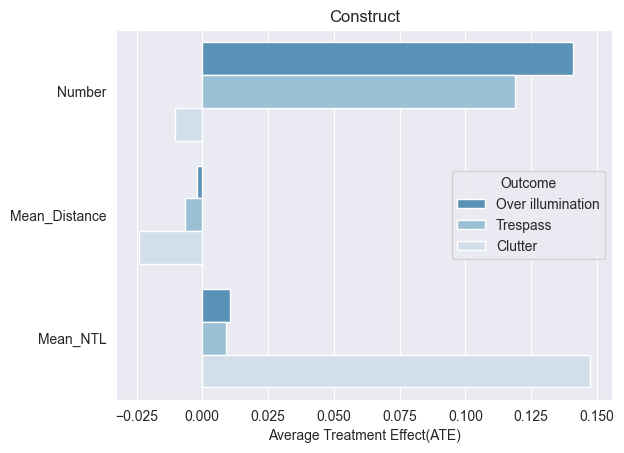

In [16]:
construct_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
construct_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
construct_effect = pd.melt(construct_effect, id_vars=["Treatment"], var_name = "Outcome")
construct_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = construct_effect,
    y="Treatment", x="value", hue="Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)

g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title="Construct")
plt.legend(title = "Outcome", loc="center right")
plt.savefig("construct3.svg", bbox_inches = "tight")

In [17]:
scaler = MinMaxScaler()

W = scaler.fit_transform(data[[c for c in features if c not in ['industrial', 'industrial_mean_distance', 'industrial_mean_NTL']]].values)
T = scaler.fit_transform(data[['industrial', 'industrial_mean_distance', 'industrial_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "industrial"
Summary2 = pd.concat([Summary2, summary], axis = 0)
Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.093,0.040,2.294,0.022,0.026,0.159,brownfield
1,0,Y1,0.037,0.034,1.082,0.279,-0.019,0.093,brownfield
2,0,Y2,0.092,0.055,1.673,0.094,0.002,0.182,brownfield
0,0,Y0,0.150,0.037,4.030,0.000,0.089,0.211,construction
1,0,Y1,0.121,0.029,4.144,0.000,0.073,0.169,construction
2,0,Y2,0.113,0.050,2.254,0.024,0.031,0.195,construction
0,0,Y0,0.008,0.014,0.564,0.573,-0.015,0.031,industrial
1,0,Y1,-0.015,0.014,-1.066,0.287,-0.038,0.008,industrial
2,0,Y2,-0.015,0.015,-1.005,0.315,-0.039,0.009,industrial


In [18]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['grass', 'grass_mean_distance', 'grass_mean_NTL']]].values)
T = scaler.fit_transform(data[['grass', 'grass_mean_distance', 'grass_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)
est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary3 = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary3.reset_index(inplace=True)

Summary3["Treatment"] = "grass"
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.906,0.046,19.770,0.000,0.830,0.981,grass
1,0,Y1,0.628,0.049,12.788,0.000,0.547,0.709,grass
2,0,Y2,0.040,0.024,1.677,0.094,0.001,0.079,grass


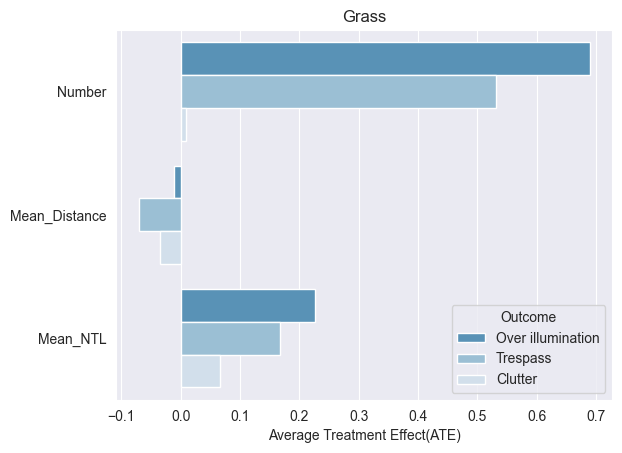

In [19]:
grass_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
grass_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
grass_effect = pd.melt(grass_effect, id_vars=["Treatment"], var_name = "Outcome")
grass_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = grass_effect,
    y = "Treatment", x = "value", hue = "Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)

g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title = "Grass")
plt.savefig("grass5.svg", bbox_inches = "tight")

In [20]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['farmland', 'farmland_mean_distance', 'farmland_mean_NTL']]].values)
T = scaler.fit_transform(data[['farmland', 'farmland_mean_distance', 'farmland_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "farmland"
Summary3 = pd.concat([Summary3, summary], axis = 0)
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.906,0.046,19.770,0.000,0.830,0.981,grass
1,0,Y1,0.628,0.049,12.788,0.000,0.547,0.709,grass
2,0,Y2,0.040,0.024,1.677,0.094,0.001,0.079,grass
0,0,Y0,-0.147,0.025,-5.877,0.000,-0.188,-0.106,farmland
1,0,Y1,-0.155,0.034,-4.544,0.000,-0.211,-0.099,farmland
2,0,Y2,-0.024,0.017,-1.430,0.153,-0.052,0.004,farmland


In [21]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['forest', 'forest_mean_distance', 'forest_mean_NTL']]].values)
T = scaler.fit_transform(data[['forest', 'forest_mean_distance', 'forest_mean_NTL', ]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "forest"
Summary3 = pd.concat([Summary3, summary], axis = 0)
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.906,0.046,19.770,0.000,0.830,0.981,grass
1,0,Y1,0.628,0.049,12.788,0.000,0.547,0.709,grass
2,0,Y2,0.040,0.024,1.677,0.094,0.001,0.079,grass
0,0,Y0,-0.147,0.025,-5.877,0.000,-0.188,-0.106,farmland
1,0,Y1,-0.155,0.034,-4.544,0.000,-0.211,-0.099,farmland
2,0,Y2,-0.024,0.017,-1.430,0.153,-0.052,0.004,farmland
0,0,Y0,0.082,0.021,3.857,0.000,0.047,0.116,forest
1,0,Y1,0.021,0.020,1.021,0.307,-0.013,0.054,forest
2,0,Y2,-0.093,0.021,-4.431,0.000,-0.128,-0.059,forest


In [22]:
Summary.loc[Summary["Y"]=="Y0", "Y"] = "Over Illumination"
Summary.loc[Summary["Y"]=="Y1", "Y"] = "Trespass"
Summary.loc[Summary["Y"]=="Y2", "Y"] = "Clutter"

Summary.rename(columns={"Y": "Outcome"}, inplace = True)

In [23]:
Summary2.loc[Summary2["Y"]=="Y0", "Y"] = "Over Illumination"
Summary2.loc[Summary2["Y"]=="Y1", "Y"] = "Trespass"
Summary2.loc[Summary2["Y"]=="Y2", "Y"] = "Clutter"

Summary2.rename(columns={"Y": "Outcome"}, inplace = True)

In [24]:
Summary3.loc[Summary3["Y"]=="Y0", "Y"] = "Over Illumination"
Summary3.loc[Summary3["Y"]=="Y1", "Y"] = "Trespass"
Summary3.loc[Summary3["Y"]=="Y2", "Y"] = "Clutter"

Summary3.rename(columns = {"Y": "Outcome"}, inplace = True)

In [25]:
Summarys = [Summary, Summary2, Summary3]

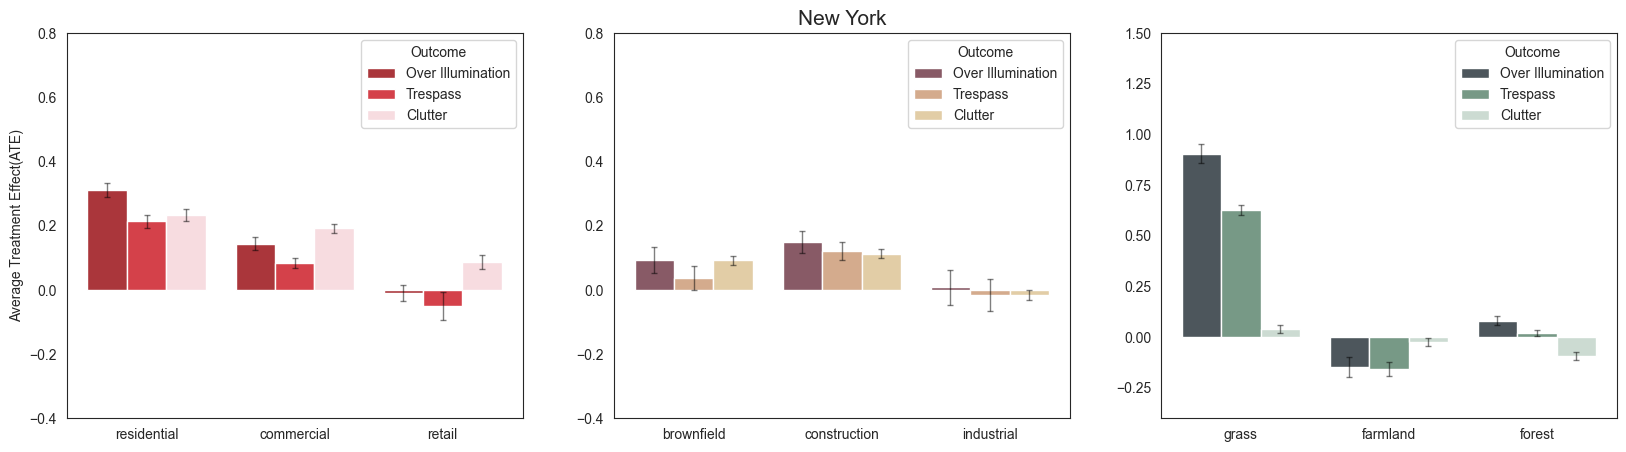

In [28]:
import pandas as pd
import seaborn as sns


# plt.figure(figsize = (20, 5))
sns.set_style("white")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

flatui = ["#BD2329", "#EC2835", "#FCD7DD"]
sns.set_palette(flatui)

sns.barplot(
    data = Summary,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[0]
)

flatui = ["#8f5362", "#e0a981", "#ecd09c"]
sns.set_palette(flatui)

axes[1] = sns.barplot(
    data = Summary2,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[1]
)

# flatui = ["#79b4a0", "#a3c8a4", "#d4daa1"]
# sns.set_palette(flatui)

flatui = ["#4A565F", "#719F85", "#CADDD1"]
sns.set_palette(flatui)

axes[2] = sns.barplot(
    data = Summary3,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[2]
)

for index in range(3):
    x = Summarys[index]["Treatment"]
    y = Summarys[index]["point_estimate"]
    yerr = Summarys[index]["stderr"]
    
    bars = [c for c in axes[index].get_children() if isinstance(c, matplotlib.patches.Rectangle)]
    bars = bars[:-1]
    
    for i, bar in enumerate(bars):
            height = bar.get_height()
            x_pos = bar.get_x() + bar.get_width() / 2
            axes[index].errorbar(x = x_pos, y = height, yerr = yerr.iloc[i], fmt = 'none', capsize = 2, color = 'black', elinewidth = 1, alpha = 0.5)

# plt.savefig("ATE2.svg", bbox_inches = "tight")
axes[0].set(xlabel = '', ylabel = "Average Treatment Effect(ATE)")

# axes[0].legend().set_visible(False)
# axes[1].legend().set_visible(False)

axes[1].set(xlabel = '', ylabel = "")
axes[0].set_ylim([-0.4, 0.8])
axes[1].set_ylim([-0.4, 0.8])
axes[1].set_title("New York", fontsize = 15)
axes[2].set_ylim([-0.4, 1.5])
axes[2].set(xlabel = '', ylabel = "")

plt.savefig("ATE_NY.svg", bbox_inches = "tight")

In [35]:
data[["residential", "commercial", "retail", "brownfield", "construction", "industrial", "grass", "farmland", "forest", "Over_illumination", "Trespass", "Clutter"]].corr()

,residential,commercial,retail,brownfield,construction,industrial,grass,farmland,forest,Over_illumination,Trespass,Clutter
residential,1.000000,0.487346,0.207647,0.199052,-0.094548,0.133141,0.197714,-0.019465,-0.112484,0.449982,0.403501,0.203771
commercial,0.487346,1.000000,0.596199,0.601294,0.443337,0.199149,0.288679,0.021711,-0.046175,0.717630,0.375849,0.181972
retail,0.207647,0.596199,1.000000,0.567564,0.472152,0.115931,0.182829,-0.070967,0.070740,0.627858,0.187588,0.090576
brownfield,0.199052,0.601294,0.567564,1.000000,0.603769,0.213317,0.194097,-0.019330,0.010999,0.546816,0.118519,0.085119
construction,-0.094548,0.443337,0.472152,0.603769,1.000000,-0.047921,0.199320,-0.074886,0.115983,0.421208,-0.002375,-0.019915
industrial,0.133141,0.199149,0.115931,0.213317,-0.047921,1.000000,0.063281,0.100144,-0.112862,0.250663,-0.061590,-0.090134
grass,0.197714,0.288679,0.182829,0.194097,0.199320,0.063281,1.000000,0.097692,0.043349,0.685291,0.217337,0.090322
farmland,-0.019465,0.021711,-0.070967,-0.019330,-0.074886,0.100144,0.097692,1.000000,-0.064941,-0.019765,-0.022857,0.009071
forest,-0.112484,-0.046175,0.070740,0.010999,0.115983,-0.112862,0.043349,-0.064941,1.000000,0.030826,-0.080207,-0.100032
Over_illumination,0.449982,0.717630,0.627858,0.546816,0.421208,0.250663,0.685291,-0.019765,0.030826,1.000000,0.297270,0.105989
